# HAAR LIKE FEATURES

## Dataset Builder 

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.transform import resize
from joblib import delayed, Parallel
from tqdm import tqdm_notebook
from os.path import join
from skimage import io
from os import listdir
from glob import glob
import numpy as np
import re
import os

In [2]:
BASEROOT, ANNOTATIONS, PICTURES = 'data', 'annotations', 'pictures'
FROMNSET, TONSET = (1, 2)

CANDIDATES = ['set{0:02d}'.format(nset) 
              for nset in range(FROMNSET, TONSET)]

In [3]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def process_header(line):
    template = r"[+-]?\d+(?:\.\d+)?"
    label = line.split("'")[1]
    frames = re.findall(template, line)
    return (label, ) + tuple(map(int, frames)) 

def process_coordinates(lines, i, n=4):
    coords = lines[i + 1].replace('pos =[', '')
    coords = coords.replace(']', '').replace(';', '')
    coords = chunks(list(map(float, coords.split())), n)
    return list(coords)
    
def fill_coords_header(line, lines, i, coords, header):
    if line[:3] == 'lbl':
        coord = process_coordinates(lines, i)
        header.append(process_header(line))
        coords.append(coord)
        
def get_coords_header(fcoord):
    coords, header = list(), list()
    lines = open(fcoord).readlines()
    for i, line in enumerate(lines):
        args = [line, lines, i, coords, header]
        fill_coords_header(*args)
    return coords, header

def build_triplets(setscoords, setsimages):
    image, coords, header = list(), list(), list()
    for fcoord, fimage in zip(setscoords, setsimages):
        _crds, _hder = get_coords_header(fcoord)
        _ = coords.append(_crds), header.append(_hder)
        image.append(glob(join(fimage, '*')))
    return image, header, coords

In [4]:
images, headers, coordinates = list(), list(), list()

for candidate in tqdm_notebook(CANDIDATES):
    setscoords = glob(join(BASEROOT, ANNOTATIONS, candidate, '*'))
    setsimages = glob(join(BASEROOT, candidate, '*'))
    image, header, coords = build_triplets(setscoords, setsimages)
    _ = images.append(image), headers.append(header)
    coordinates.append(coords)

In [5]:
Images, Coords, Labels = list(), list(), list()

for i in tqdm_notebook(range(len(images))):
    iterator = zip(images[i], headers[i], coordinates[i])
    for I, H, C in iterator:
        for header, coord in zip(H, C):
            _from, to = (header[1] - 1, header[2])
            if len(coord) == len(I[_from: to]):
                Images.extend(I[_from: to])
                Coords.extend(coord)
                Labels.extend([header[0]]*len(coord))
Coords = np.array(Coords, dtype=np.int)

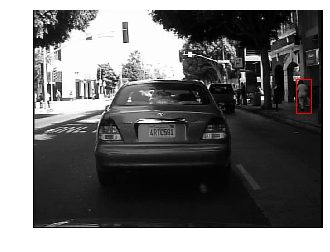

In [6]:
INDEX = 13214

sample = io.imread(Images[INDEX], as_gray=True)
fig, ax = plt.subplots(1)
ax.imshow(sample, cmap='gray')

rect = patches.Rectangle(Coords[INDEX][:2], Coords[INDEX][2], Coords[INDEX][3], linewidth=1, 
                         edgecolor='r', facecolor='none')
ax.axis('off')
ax.add_patch(rect)

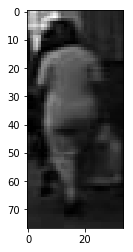

In [7]:
for pict, coord, label in zip(Images[INDEX:INDEX + 1], Coords[INDEX:INDEX + 1], Labels[13214:INDEX + 1]):
    img = io.imread(pict, as_gray=True)
    s = img[coord[1]:coord[1] + coord[3], coord[0]:coord[0] + coord[2]]
    plt.imshow(s, cmap='gray')

In [ ]:
#TODO DAVID opencv formatfile ----> img/img2.jpg  2  100 200 50 50   50 30 25 25  